# Distributed Bloom for Sequence Classification using Prompt Tuning

In this example, we showcase how Bloom model can be efficiently adapted in decentralized fashion. In particular, servers maintain the Bloom transformer, which is kept unchanged during adaptation, and learn only a few prefix tokens and a classification head.  

### Import all dependences and prepare the environment

In [1]:
%env CUDA_VISIBLE_DEVICES=7
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# General 
import torch
import pandas as pd
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Distributed
import hivemind
from src.client.remote_model import DistributedBloomForSequenceClassification


# HF imports
import transformers
import datasets


# Visualization dependencies
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

env: CUDA_VISIBLE_DEVICES=7


### Config

In [2]:
MODEL_NAME='bigscience/test-bloomd-6b3'
INITIAL_PEERS = ['/ip4/127.0.0.1/tcp/30000/p2p/QmatpEv91gMHUyARrVV4t1L2UTJP1GxjmdP3s5NwDhEZtn']
BLOCK_UID=['bloom6b3.3']

TASK="single_label_classification"
NUM_PREFIX_TOKENS=16 
NUM_LABELS=2
DEVICE='cpu'

### Prepare the distributed Bloom model

In [3]:
model = DistributedBloomForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    initial_peers=INITIAL_PEERS, 
    num_prefix_tokens=NUM_PREFIX_TOKENS, 
    num_labels=NUM_LABELS
).to(DEVICE)
assert len(model.transformer.h) == model.config.n_layer

def print_params(model):
    for n, p in model.named_parameters():
        print(n, p.requires_grad, p.device)
        if p.requires_grad:
            print(p)

Jul 12 18:53:19.137 [WARN] [/home/dbaranchuk/bloom-demo/notebooks/../src/client/remote_sequential.py.__init__:29] RemoteSequential is in active development; expect adventures
Some weights of DistributedBloomForSequenceClassification were not initialized from the model checkpoint at bigscience/test-bloomd-6b3 and are newly initialized: ['prompt_embeddings.weight', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print_params(model)

transformer.word_embeddings.weight False cpu
transformer.word_embeddings_layernorm.weight False cpu
transformer.word_embeddings_layernorm.bias False cpu
transformer.ln_f.weight False cpu
transformer.ln_f.bias False cpu
transformer.prompt_embeddings.weight True cpu
Parameter containing:
tensor([[-0.0044, -0.0212,  0.0040,  ..., -0.0201, -0.0145,  0.0361],
        [ 0.0545, -0.0034, -0.0082,  ..., -0.0160,  0.0302,  0.0047],
        [-0.0290,  0.0197,  0.0097,  ...,  0.0170,  0.0276,  0.0223],
        ...,
        [-0.0014, -0.0087, -0.0343,  ...,  0.0149,  0.0005,  0.0202],
        [-0.0039,  0.0030,  0.0116,  ..., -0.0233, -0.0120, -0.0191],
        [-0.0045,  0.0079, -0.0049,  ...,  0.0018,  0.0256,  0.0036]],
       requires_grad=True)
score.weight True cpu
Parameter containing:
tensor([[ 0.0005,  0.0222,  0.0263,  ..., -0.0138,  0.0251,  0.0053],
        [ 0.0103,  0.0161, -0.0287,  ...,  0.0355,  0.0119,  0.0065]],
       requires_grad=True)


## Dataset

This examples operates on SST dataset for binary sentence classification.

In [5]:
dataset = datasets.load_dataset("sst")
print(f'Sample example: {dataset["train"][100]}')

Jul 12 18:53:29.471 [WARN] [datasets.builder._create_builder_config:418] No config specified, defaulting to: sst/default
Jul 12 18:53:29.505 [WARN] [datasets.builder.download_and_prepare:641] Reusing dataset sst (/home/dbaranchuk/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

Sample example: {'sentence': 'It is also a testament to the integrity and vision of the band .', 'label': 0.75, 'tokens': 'It|is|also|a|testament|to|the|integrity|and|vision|of|the|band|.', 'tree': '27|24|24|22|22|21|19|17|17|18|16|15|15|26|16|20|18|19|20|21|23|23|25|25|26|27|0'}


In [6]:
tokenizer = transformers.BloomTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding='max_length', truncation=False)

tokenizer.model_max_length = 66
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["tokens"])
tokenized_datasets = tokenized_datasets.remove_columns(["tree"])

tokenized_datasets = tokenized_datasets.remove_columns(["sentence"])
tokenized_datasets = tokenized_datasets.remove_columns(["attention_mask"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["validation"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Jul 12 18:53:36.491 [WARN] [datasets.fingerprint.update_fingerprint:328] Parameter 'function'=<function tokenize_function at 0x7f35bf795670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

### Create optimizer and scheduler

In [8]:
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-4)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### Eval utils

In [11]:
moving_average = lambda x, **kw: pd.Series(x).ewm(**kw).mean().values

def eval_metrics(model, dataloader, device='cpu'):
    metric = datasets.load_metric("accuracy")
    model.eval()
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if TASK == "single_label_classification":
            batch['labels'] = batch['labels'].round().long()
            
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    return metric.compute()

### Training loop

  0%|          | 0/1335 [00:00<?, ?it/s]

Iteration: 0


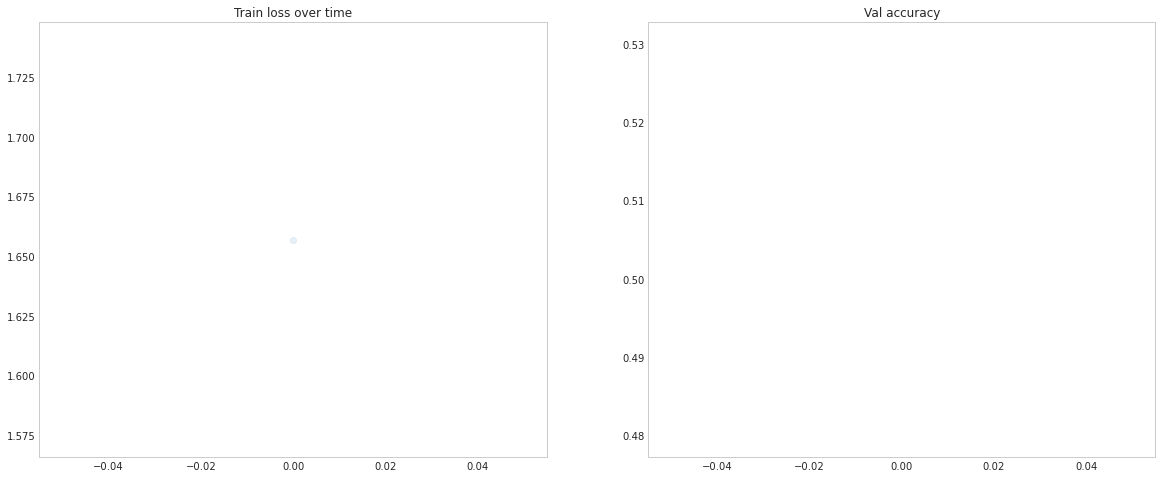

Iteration: 200


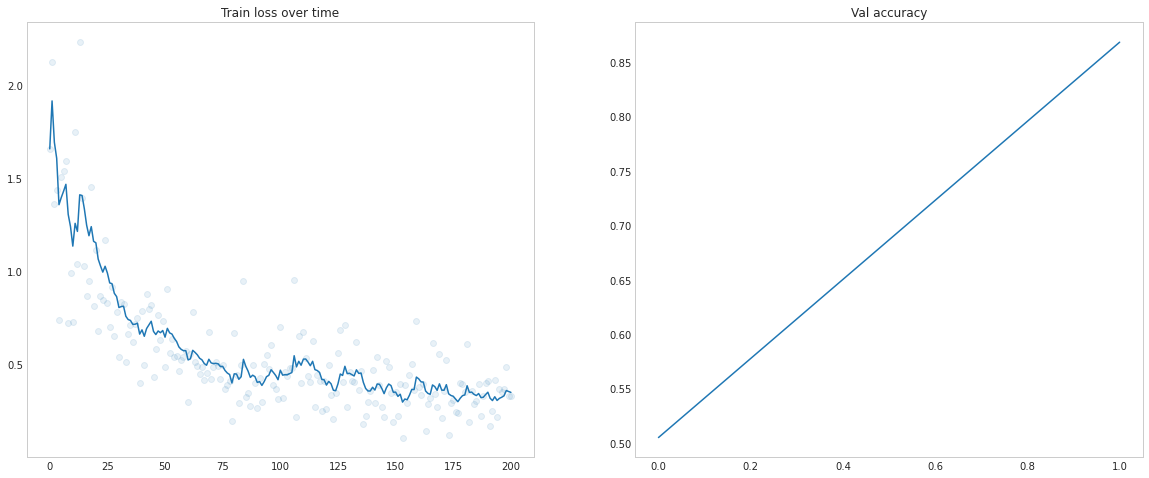

Iteration: 400


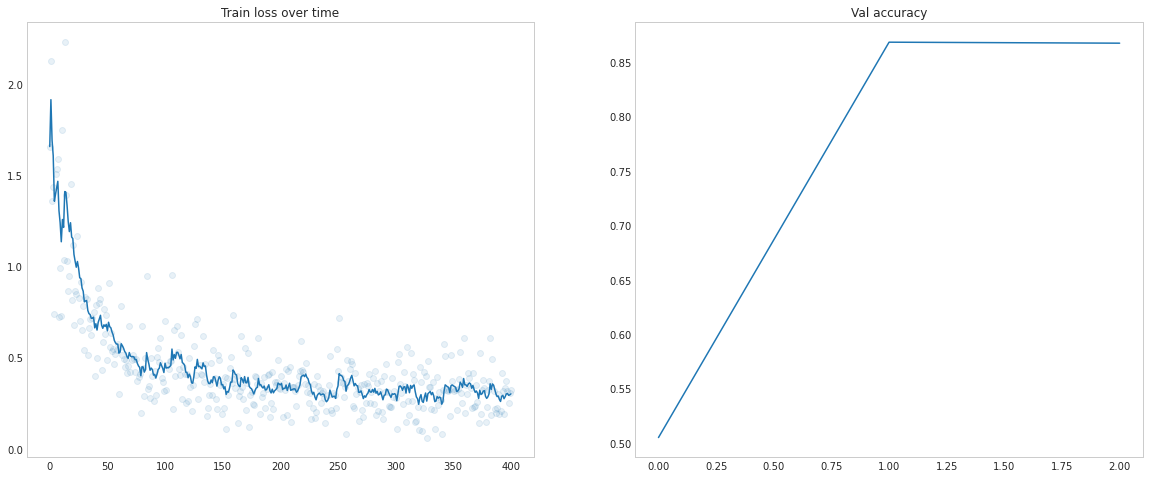

Iteration: 600


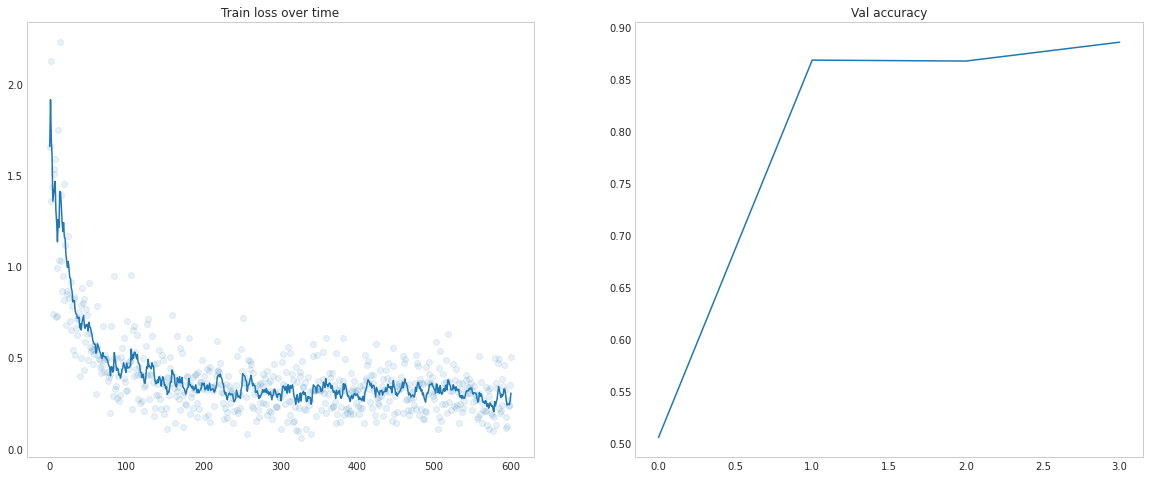

Iteration: 800


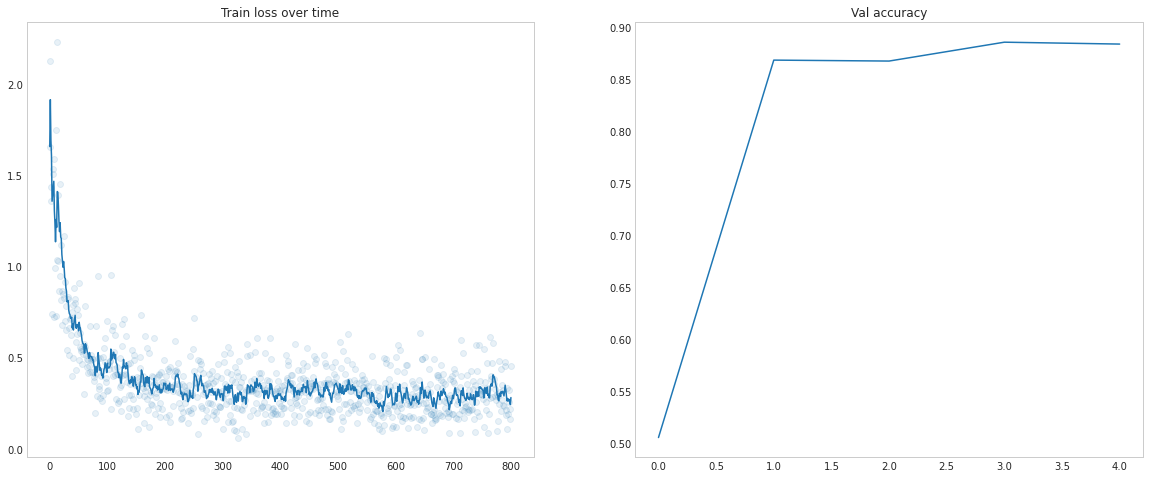

Iteration: 1000


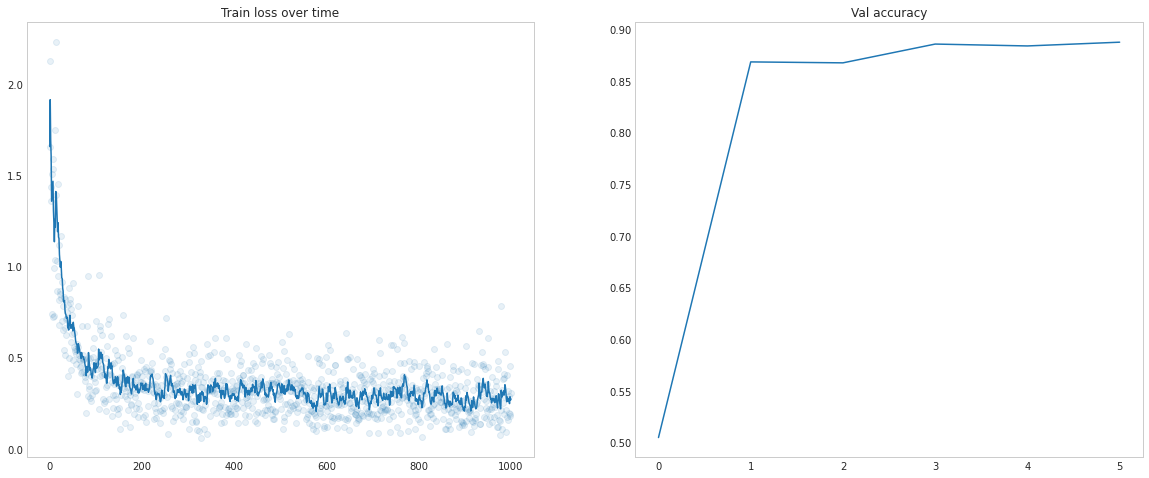

Iteration: 1200


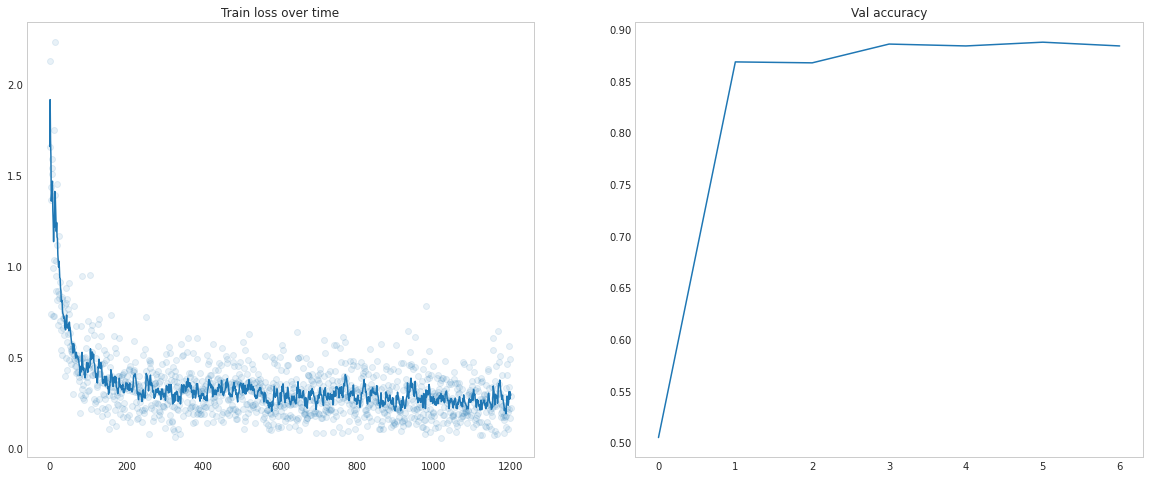

KeyboardInterrupt: 

In [12]:
progress_bar = tqdm(range(num_training_steps))

loss_history = []
accuracy_history = []

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        if TASK == "single_label_classification":
            batch['labels'] = batch['labels'].round().long()
            
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        if progress_bar.last_print_n % 200 == 0:
#             clear_output(True)
            print(f'Iteration: {progress_bar.last_print_n}')
            plt.figure(figsize=[20, 8])
            plt.subplot(1,2,1)
            plt.title('Train loss over time', fontsize=12); plt.grid();
            plt.plot(moving_average(loss_history, span=10))
            plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)
            
            accuracy = eval_metrics(model, valid_dataloader, device=DEVICE)
            accuracy_history.append(accuracy['accuracy'])
            
            plt.subplot(1,2,2)
            plt.title('Val accuracy', fontsize=12); plt.grid();
            plt.plot(accuracy_history)
            plt.show()
            
        progress_bar.update(1)

In [13]:
print('Test accuracy: ', eval_metrics(model, test_dataloader, device=DEVICE))

Test accuracy:  {'accuracy': 0.8900452488687782}


In [15]:
print_params(model)

transformer.word_embeddings.weight False cpu
transformer.word_embeddings_layernorm.weight False cpu
transformer.word_embeddings_layernorm.bias False cpu
transformer.ln_f.weight False cpu
transformer.ln_f.bias False cpu
transformer.prompt_embeddings.weight True cpu
Parameter containing:
tensor([[-0.0047, -0.0242,  0.0034,  ..., -0.0198, -0.0127,  0.0328],
        [ 0.0592, -0.0046, -0.0056,  ..., -0.0156,  0.0325,  0.0060],
        [-0.0283,  0.0199,  0.0115,  ...,  0.0177,  0.0287,  0.0225],
        ...,
        [-0.0001, -0.0061, -0.0427,  ...,  0.0128,  0.0005,  0.0224],
        [-0.0034, -0.0018,  0.0145,  ..., -0.0242, -0.0160, -0.0216],
        [-0.0054,  0.0101, -0.0069,  ...,  0.0002,  0.0273,  0.0026]],
       requires_grad=True)
score.weight True cpu
Parameter containing:
tensor([[-0.0053,  0.0154,  0.0237,  ..., -0.0059,  0.0243,  0.0105],
        [ 0.0160,  0.0228, -0.0260,  ...,  0.0276,  0.0126,  0.0012]],
       requires_grad=True)
